Notebook purpose: evaluate how efficiently we could search for catalysts using the ML model under various constraints.

The most conspicuous constraint is to find a set number of active catalysts without any unnecessary DFT calculations
What is unnecessary? --> 100% of O2 binding calculations are to actual binding sites
So we can accept a model with lower accuracy as long as it has no false positives --> only a small penalty for false negatives

Let's say we're only willing to run 5 DFT O2 binding calculations, and we want basically all of them to show that we found active sites. We'd probably want each of these to be per catalyst, to show that we've found 5 unique active catalysts. Assuming we're working with 10% of the data as a "test" set, that's about 27 calalysts, so we want to pick the ones that the model is most confident have at least 1 site that binds O2.

Really, this is a question of whether the active sites for a set of catalysts are most likely to actually be binding
Can order by log-loss and take that as an estimate of uncertainty (is that a fair expectation?)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

plt.rcParams.update({'font.size': 16})

In [2]:
from ngcc_ml import data_tools
from ngcc_ml import skl_tools

In [11]:
"""
def group_regression_kfold_evaluate(model, df_xy, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="Catalyst Name"):
    all_mae, all_mse, all_test = [], [], []
    all_perm_importance = []
    split_groups = GroupKFold(n_splits=n_splits).split(df_xy[feature_cols], df_xy[target_col], df_xy[group_col])
    for train_inds, test_inds in split_groups:
        model_kfg = clone(model)
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(BindingEnergy_pred=y_test_group_pred)
        mse = mean_squared_error(y_test_group, y_test_group_pred)
        mae = mean_absolute_error(y_test_group, y_test_group_pred)
        perm_importance = permutation_importance(model_kfg, X_test_group, y_test_group, n_repeats=10)
        all_perm_importance.append(perm_importance)
        all_test.append(test)
        all_mae.append(mae)
        all_mse.append(mse)
        
        print('MAE of MLP on test set: {:.4f}'.format(mae))
    print("mean:", np.mean(all_mae))
    print("stdev:", np.std(all_mae))
    df_pred_aug = pd.concat(all_test)
    return all_mse, all_mae, df_pred_aug, all_perm_importance
"""

def scale_data(train, test, feature_cols, target_col):
        scaler = StandardScaler()
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        X_train_group = scaler.fit_transform(X_train_group)
        X_test_group = scaler.transform(X_test_group)
        y_test_group = test[target_col]
        y_train_group = train[target_col]
        return X_train_group, y_train_group, X_test_group, y_test_group

    
def group_regression_kfold_evaluate(df, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="Catalyst Name"):
    
    all_mae, all_mse, all_test = [], [], []
    all_perm_importance = []
    split_groups = GroupKFold(n_splits=n_splits).split(df[feature_cols], df[target_col], df[group_col])
    for train_inds, test_inds in split_groups:
        df_xy = df.copy()
        model_kfg = MLPRegressor(max_iter=30000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group, y_train_group, X_test_group, y_test_group = scale_data(train, test, feature_cols, target_col)
        model_kfg.fit(X_train_group, y_train_group)
        score = model_kfg.score(X_test_group, y_test_group)
        y_test_group_pred = model_kfg.predict(X_test_group)
        test = test.assign(Overpotential_pred=y_test_group_pred)
        mse = mean_squared_error(y_test_group, y_test_group_pred)
        mae = mean_absolute_error(y_test_group, y_test_group_pred)
        perm_importance = permutation_importance(model_kfg, X_test_group, y_test_group, n_repeats=10)
        all_perm_importance.append(perm_importance)
        all_test.append(test)
        all_mae.append(mae)
        all_mse.append(mse)

        print('MAE of MLP on test set: {:.4f}'.format(mae))
    print("mean:", np.mean(all_mae))
    print("stdev:", np.std(all_mae))
    df_pred_aug = pd.concat(all_test)
    return all_mse, all_mae, df_pred_aug, all_perm_importance

In [21]:
df_all = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv")
df = df_all.copy()
df["Doesitbind"] = df["Doesitbind"].astype("int")
df_inactive = df[df["Doesitbind"] == 0]
df_spec = df.copy()
# set to 0 if it doesn't bind
df_spec.loc[df_spec['Doesitbind'] == 0, 'BindingEnergy'] = 0.0
df = df[df["Doesitbind"] == 1]

In [22]:
df_all.shape

(4141, 36)

In [5]:
df.columns

Index(['Unnamed: 0', 'Atom Number', 'Catalyst Name', 'CatalystO2File',
       'Element', 'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge'],
      dtype='object')

In [12]:
feature_cols = ["SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"]
#not_scaled_cols = ["OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"]
#df_scale = data_tools.process_data(df, scaledCols=list(set(feature_cols) - set(not_scaled_cols)))
mlp_spec = MLPRegressor(max_iter=30000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
gkf_mse_spec, gkf_mae_spec, df_gkf_spec, gkf_permute = group_regression_kfold_evaluate(df, feature_cols, target_col="BindingEnergy")

MAE of MLP on test set: 0.0718
MAE of MLP on test set: 0.1102
MAE of MLP on test set: 0.0570
MAE of MLP on test set: 0.0792
MAE of MLP on test set: 0.0684
MAE of MLP on test set: 0.0802
MAE of MLP on test set: 0.0654
MAE of MLP on test set: 0.0924
MAE of MLP on test set: 0.0727
MAE of MLP on test set: 0.0827
mean: 0.07801006763134052
stdev: 0.014248481508956445


In [13]:
graph_feature_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "ring_nitrogens"}
graph_gkf_mse_spec, graph_gkf_mae_spec, graph_df_gkf_spec, graph_gkf_permute = group_regression_kfold_evaluate(df, graph_feature_cols, target_col="BindingEnergy")

MAE of MLP on test set: 0.1289
MAE of MLP on test set: 0.1201
MAE of MLP on test set: 0.1119
MAE of MLP on test set: 0.1385
MAE of MLP on test set: 0.1264
MAE of MLP on test set: 0.1198
MAE of MLP on test set: 0.1143
MAE of MLP on test set: 0.1291
MAE of MLP on test set: 0.1311
MAE of MLP on test set: 0.1303
mean: 0.1250414911474317
stdev: 0.007854541623503002


In [17]:
gkf_permute

[{'importances_mean': array([ 4.95300660e-01,  2.96247264e-02,  1.61768219e-01,  8.25470682e-02,
          4.98184432e-02,  6.99330024e-02,  1.68049939e-02,  7.89911173e-03,
          7.53373183e-03, -2.72898332e-04,  8.36974738e-02,  1.01906935e-01,
          2.40816717e-01,  7.37159175e-02,  3.89545823e-02,  2.48951399e-04,
          0.00000000e+00,  1.52296449e-01,  0.00000000e+00,  5.54310614e-02,
          2.50207014e-03,  8.99711522e-02]),
  'importances_std': array([0.07403404, 0.01117307, 0.05295906, 0.02384212, 0.02205024,
         0.02334275, 0.00364999, 0.00891342, 0.00798806, 0.00119858,
         0.03522918, 0.04405798, 0.07494052, 0.04556667, 0.02194833,
         0.00516591, 0.        , 0.05339167, 0.        , 0.05002499,
         0.01465137, 0.02794404]),
  'importances': array([[ 4.59458942e-01,  4.93883097e-01,  6.04263518e-01,
           4.19627758e-01,  3.50180817e-01,  5.58671347e-01,
           5.49549498e-01,  4.40597958e-01,  5.62888769e-01,
           5.13884900e

In [24]:
feature_cols

['SpinDensity',
 'ChElPGNeutralCharge',
 'ChargeDifference',
 'IonizationEnergy',
 'OrthoOrPara',
 'Meta',
 'FartherThanPara',
 'DistanceToN',
 'NumberOfHydrogens',
 'IsInRingSize6',
 'IsInRingSize5',
 'NeighborSpinDensity',
 'NeighborChElPGCharge',
 'NeighborChargeDifference',
 'AromaticExtent',
 'RingEdge',
 'NumNitrogens',
 'NumHeteroatoms',
 'charge',
 'atom_plane_deviation',
 'ring_plane_deviation',
 'ring_nitrogens']

In [18]:
feature_names = [
    "Spin Density",
    "Neutral Partial Charge",
    "Partial Charge Difference",
    "Ionization Energy",
    "Ortho or Para",
    "Meta",
    "Farther than Para",
    "Nearest Nitrogen Distance",
    "Hydrogen Count",
    "Is in Ring Size 6",
    "Is in Ring Size 5",
    "Neighbor Spin Density",
    "Neighbor Partial Charge",
    "Neighbor Charge Difference",
    "Aromatic Extent",
    "Ring Embedding Count",
    "Molecule Nitrogens Count",
    "Molecule Heteroatom Count",
    "Molecule Charge",
    "Atom Planar Deviation",
    "Aromatic Nitrogens",
    "Ring Nitrogens"
    ]
print(len(feature_names))
print(len(feature_cols))

22
22


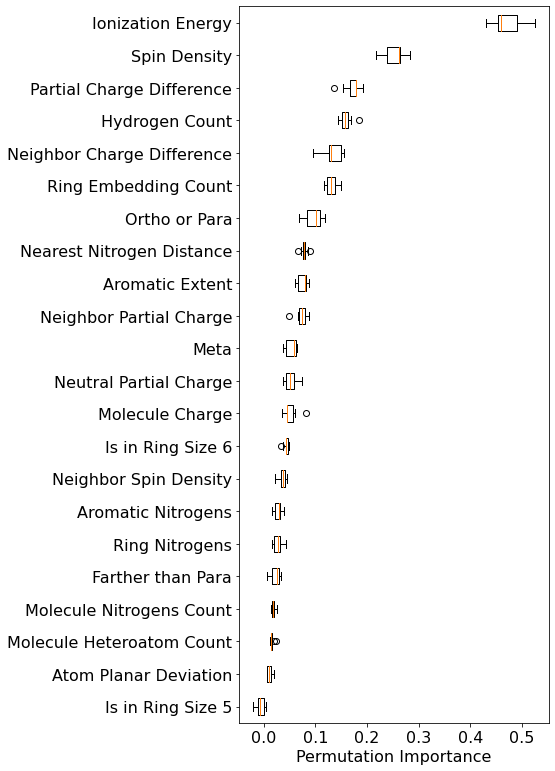

In [19]:
plt.rcParams.update({'figure.autolayout': True})

imp_mean = np.zeros(gkf_permute[0].importances.shape)
imp_std_mean = np.zeros(gkf_permute[0].importances_std.shape)

for i in range(len(gkf_permute)):
    imp_mean += gkf_permute[i].importances
    imp_std_mean += gkf_permute[i].importances_std
    
imp_mean /= gkf_permute[0].importances.shape[1]
imp_std_mean /= gkf_permute[0].importances_std.shape


#feature_names = np.array(list(feature_cols))
feature_names = np.array(feature_names)

imp_mean_mean = np.mean(imp_mean, axis=1)
perm_sorted_idx = imp_mean_mean.argsort()

fig = plt.gcf()
#fig, ax = plt.subplot(1,1)
#ax.set_yticklabels(features[tree_importance_sorted_idx])
#ax.set_yticks(tree_indices)
#ax.set_ylim((0, len(rfc.feature_importances_)))
#plt.boxplot(imp_mean[0:10].T, vert=False)
plt.boxplot(imp_mean[perm_sorted_idx].T, vert=False,
            labels=feature_names[perm_sorted_idx])
#fig.tight_layout()
fig.set_size_inches(8,11)
plt.xlabel("Permutation Importance")
plt.savefig("FFNN_regression_permutation_importance.png")
#plt.show()

In [ ]:
mae = mean_absolute_error(y_test_group, y_pred)
mae

In [ ]:
train = df
test = df_inactive
X_train_group = train[feature_cols]
y_train_group = train["BindingEnergy"]
X_test_group = test[feature_cols]
y_test_group = test["BindingEnergy"]

model = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
model.fit(X_train_group, y_train_group)

In [ ]:
y_pred = model.predict(X_test_group)
plt.hist(y_pred, bins=30)
plt.hist(df["BindingEnergy"], bins=30)

In [ ]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "AverageBondLength",  "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale = data_tools.process_data(df, scaledCols=list(feature_cols - not_scaled_cols))
mlp = MLPRegressor(max_iter=20000, hidden_layer_sizes=(512, 256, 128, 16), learning_rate="adaptive")
gkf_mse, gkf_mae, df_gkf = group_regression_kfold_evaluate(mlp, df_scale, feature_cols, target_col="BindingEnergy")

In [ ]:
df_gkf.columns

In [ ]:
df_be = df_gkf.sort_values(by="BindingEnergy")[["Catalyst Name", "Atom Number", "BindingEnergy", "BindingEnergy_pred"]]

In [ ]:
df_be.to_csv("df_BindingEnergy_pred.csv")

The situation is a little different now than before, as the model has only made predictions on the sites that are known to be active. To really put together both the classification and regression algorithms, we need to make regression predictions for the inactive sites as well.

1. If we don't train on inactive data, what do the predictions on the inactive sites look like?
2. If we set a fixed value for the inactive data and train on that, does that have a negative effect on the accuracy for predicting on the active sites?

In [ ]:
def search_for_most_active_sites(df_catalysts, order_col, feature_cols, target_col="Doesitbind", find_num=10):
    """
    df_catalysts (pandas dataframe): catalysts to search
    order_col (str): column name to sort catalysts by. Expected for predict_proba or random values
    """
    df_sort = df_catalysts.sort_values(by=order_col, ascending=False)
    df_best = df_catalysts.sort_values(by="BindingEnergy").head(15) # get strongest binding
    df_best.index

In [ ]:
df_ts = df_gkf_spec.copy()
df_ts_best = df_ts.sort_values(by="BindingEnergy").head(15)[["BindingEnergy", "BindingEnergy_pred"]]

df_ts_pred = df_ts.sort_values(by="BindingEnergy_pred")
df_ts_pred = df_ts_pred.assign(pred_rank=range(df_ts_pred.shape[0]))

In [ ]:
ts_rr_all = []
nsims = 1000
for j in range(nsims):
    df_ts_rand = df_ts.assign(random_ordering=np.random.rand(df_ts.shape[0]))
    df_ts_rand = df_ts_rand.sort_values(by="random_ordering")
    df_ts_rand = df_ts_rand.assign(rand_rank=range(df_ts_rand.shape[0]))

    ts_pred = df_ts_pred.loc[df_ts_best.index].pred_rank.sort_values()
    ts_rr = df_ts_rand.loc[df_ts_best.index].rand_rank.sort_values()
    ts_rr_pred = []
    for i in range(15):
        ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

    ts_rr_all.append(ts_rr_pred)

In [ ]:
ts_rr_arr = np.array(ts_rr_all)
ts_mean = np.mean(ts_rr_arr, axis=0)
ts_std = np.std(ts_rr_all, axis=0)

print(ts_mean)
print()
print(ts_std)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plt.bar(np.arange(15)+1, ts_mean, yerr=ts_std, capsize=5)
plt.xlabel("Number of Strongest Binding Sites Found")
plt.ylabel(r"Active Site Search Speedup Ratio")
ax.set_xticks(np.arange(15)+1)
plt.savefig("ClassRegressionSpeedup.png")

In [ ]:

print(ts_rr.iloc[4], ts_rr.iloc[9])

In [ ]:
ts_rr_pred = []
for i in range(15):
    ts_rr_pred.append((ts_rr.iloc[i]+1)/(ts_pred.iloc[i]+1))

In [ ]:
# for each index in df_ts_best
# 

In [ ]:
l_O2, c_O2 = search_for_active_catalysts(df_ts, order_col="random_ordering", feature_cols=feature_cols, find_num=100)
print(len(l_O2), c_O2)
l_t, c_t = search_for_active_catalysts(df_ts, order_col="Doesitbind_predproba", feature_cols=feature_cols, find_num=100)
print(len(l_t), c_t)